In [62]:
2**(-1000/10000)

0.9330329915368074

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constant
from scipy.optimize import curve_fit
import random
import math
import scipy.stats as stats
from tqdm.notebook import tqdm, trange
import ipywidgets as widgets
import mesa
import pandas as pd
from matplotlib.patches import Circle


In [51]:
class Company(mesa.Agent):
    def __init__(self, unique_id, model, value=100, innovation = 0.1, initial_experience = 1):
        
        super().__init__(unique_id, model)
        self.value = value
        self.original_value = value 
        self.innovation = innovation + self.random.uniform(innovation*-0.1,innovation*0.1)
        self.experience = initial_experience
    
    def step(self):
        if self.value > 0:
            self.agility = 1/math.log(self.value, 100000)

            if self.random.random() <= self.agility:
                self.innovate()
                
            self.innovate()

            self.market_fluctuation()
            
            self.innovation = 2**(-self.value/1000)
            
        if self.value < 0:
            self.value = 0
        
    def innovate(self):
        # Isolated randomised success from innovation
        invested_funds = self.value * self.innovation

        if self.random.random() >= self.innovation:
            self.value -= invested_funds
        else:
            self.value += invested_funds #*10**(2*self.innovation)

        self.experience += self.innovation
        
    def market_fluctuation(self):
        # In future, may tie this to brownian motion   
        # if self.random.random() > 0.5:
        #     self.value += self.value/(self.innovation*np.log(self.experience))
        # else:
        #     self.value -= self.value/(self.innovation*np.log(self.experience))
            
        # Can control how much a companies value follows that of the market it is in through the self.random.random
        market_link = self.model.fractional_market_movement#/self.experience
        self.value += market_link*self.random.random()*self.value
        
class Market(mesa.Model):
    
    def __init__ (self,no_companies=10,starting_value=100,innovation_parameter = 0.1, initial_experience = 1):
        
        self.schedule = mesa.time.RandomActivation(self)
        self.starting_value = starting_value
        self.no_companies = no_companies
        self.innovation = innovation_parameter
        self.init_experience = initial_experience
        self.market_tracker = 1
        self.fractional_market_movement = 0
        self.volatility = 0.05
        self.total_company_value = self.starting_value*self.no_companies
        self.init_companies()
        
    def init_companies(self):
        
        self.companies = []
        
        
        for i in range(self.no_companies):
            
            company = Company(i, self, self.starting_value,self.innovation,self.init_experience) 
            self.schedule.add(company)
         
        self.datacollector = mesa.DataCollector(
            model_reporters = { "Market_Value" : "market_tracker", "Total Company Value" : "total_company_value"} ,
            agent_reporters = { "Value": "value", "Innovation": "innovation", "Experience": "experience"}
        )
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.market_movement()
        
        self.total_company_value = 0
        for agent in self.schedule.agents:
            self.total_company_value += agent.value
            
        
    def market_movement(self):
        self.fractional_market_movement = self.random.uniform(-self.volatility,self.volatility)
        self.market_tracker = self.fractional_market_movement*self.market_tracker
        if self.market_tracker <= 0:
            self.market_tracker = -self.market_tracker


  0%|          | 0/100 [00:00<?, ?it/s]

Final total market value of Large Businesses: 6178764.477424015 with an innovation of 0.0028480129816242606
Final total market value of Small Businesses: 85010.87364340866 with an innovation of 0.5829513147071349


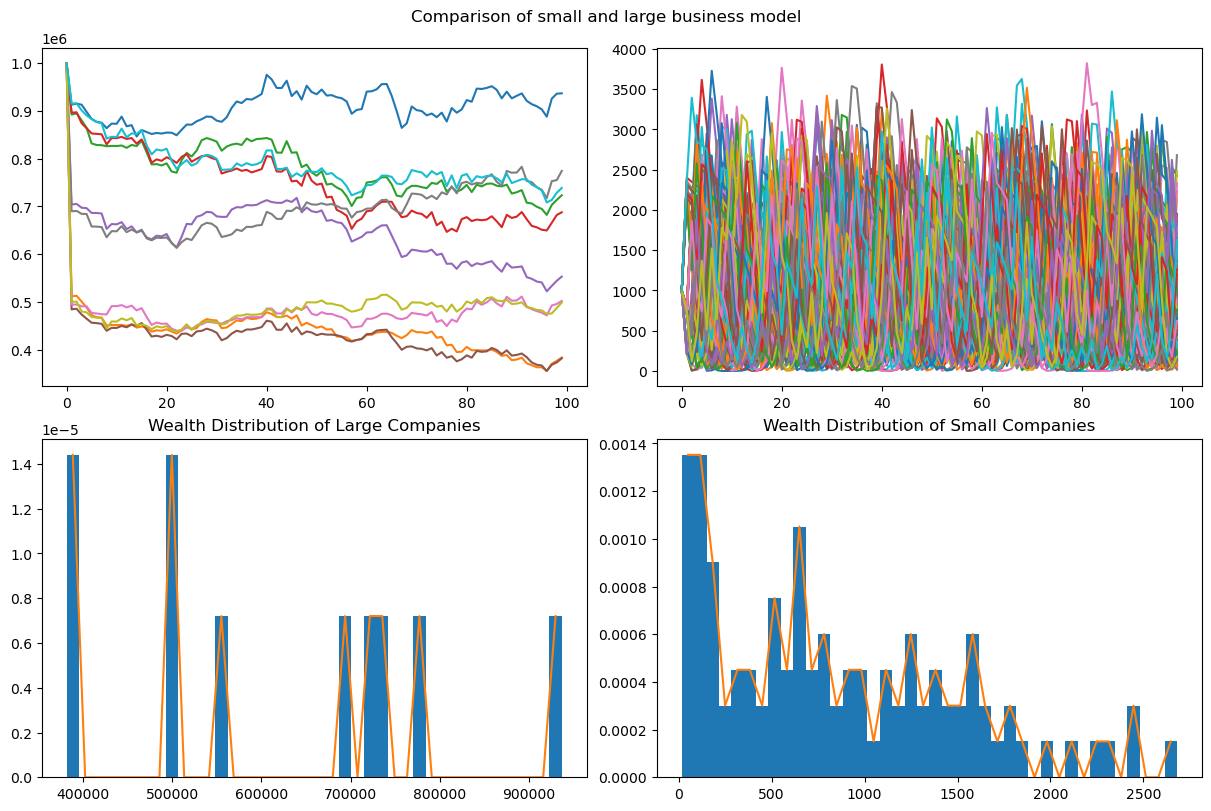

In [52]:
LargeBusinessModel = Market(no_companies = 10, starting_value = 1000000, innovation_parameter=0.3, initial_experience=50)
SmallBusinessModel = Market(no_companies = 100, starting_value = 1000, innovation_parameter=0.5, initial_experience=1)
sim_length = 100

for i in tqdm(range(sim_length)):
    LargeBusinessModel.step()
    SmallBusinessModel.step()

plt.rcParams['figure.figsize'] = [12,8]

fig,ax = plt.subplots(2,2,constrained_layout=True)
    
LargeBusinessAgentdata = LargeBusinessModel.datacollector.get_agent_vars_dataframe()
SmallBusinessAgentdata = SmallBusinessModel.datacollector.get_agent_vars_dataframe()

for i in range(LargeBusinessModel.no_companies):
    LargeAgentdata = LargeBusinessAgentdata.xs(i, level="AgentID")["Value"]
    ax[0,0].plot(LargeAgentdata)

for i in range(SmallBusinessModel.no_companies):
    SmallAgentdata = SmallBusinessAgentdata.xs(i, level="AgentID")["Value"]
    ax[0,1].plot(SmallAgentdata)
    
LargeValueDistribution = LargeBusinessAgentdata.xs(sim_length-1, level="Step")["Value"]
bin_heights, bin_edges, _ = ax[1,0].hist(LargeValueDistribution,bins = 40, density = True, stacked = True)
bin_centres = bin_edges[:-1] + np.diff(bin_edges)/2
ax[1,0].plot(bin_centres,bin_heights)
ax[1,0].set_title('Wealth Distribution of Large Companies')

SmallValueDistribution = SmallBusinessAgentdata.xs(sim_length-1, level="Step")["Value"]
bin_heights, bin_edges, _ = ax[1,1].hist(SmallValueDistribution,bins = 40, density = True, stacked = True)
bin_centres = bin_edges[:-1] + np.diff(bin_edges)/2
ax[1,1].plot(bin_centres,bin_heights)
ax[1,1].set_title('Wealth Distribution of Small Companies')

plt.suptitle('Comparison of small and large business model')

LargeBusinessModeldata = LargeBusinessModel.datacollector.get_model_vars_dataframe()
SmallBusinessModeldata = SmallBusinessModel.datacollector.get_model_vars_dataframe()

LargeBusinessFinalMarket = LargeBusinessModeldata['Market_Value'].iloc[-1]
SmallBusinessFinalMarket = SmallBusinessModeldata['Market_Value'].iloc[-1]

LargeBusinessFinalTotal = LargeBusinessModeldata['Total Company Value'].iloc[-1]
SmallBusinessFinalTotal = SmallBusinessModeldata['Total Company Value'].iloc[-1]

LargeInnovation = LargeBusinessAgentdata.xs(1, level="AgentID")["Innovation"].mean()
LargeExperience = LargeBusinessAgentdata.xs(1, level="AgentID")["Experience"].mean()

SmallInnovation = SmallBusinessAgentdata.xs(1, level="AgentID")["Innovation"].mean()
SmallExperience = SmallBusinessAgentdata.xs(1, level="AgentID")["Experience"].mean()


print(f'Final total market value of Large Businesses: {LargeBusinessFinalTotal} with an innovation of {LargeInnovation}')
print(f'Final total market value of Small Businesses: {SmallBusinessFinalTotal} with an innovation of {SmallInnovation}')



In [303]:
model = Market(no_companies = 100, starting_value = 1000, innovation_parameter=0.9)
sim_length = 100
for i in tqdm(range(sim_length)):
    model.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Index(['Value', 'Innovation', 'Experience'], dtype='object')
              Value  Innovation  Experience
Step AgentID                               
99   95         0.0         0.9        89.1
     96         0.0         0.9        89.1
     97         0.0         0.9        89.1
     98         0.0         0.9        89.1
     99         0.0         0.9        89.1
(10000, 3)


Text(0.5, 1.0, 'Value of companies over time')

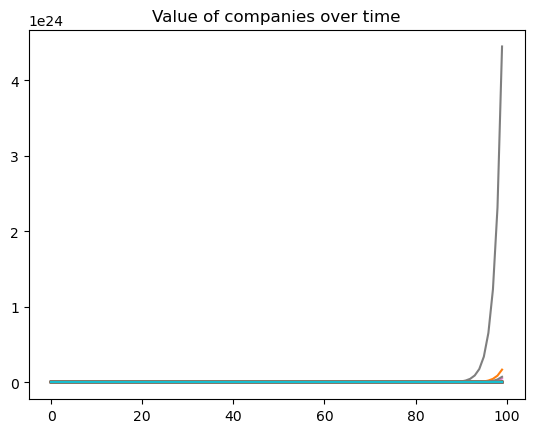

In [302]:
Modeldata = model.datacollector.get_agent_vars_dataframe()
print(Modeldata.keys())
print(Modeldata.tail())
# print(Modeldata['Value'])
for i in range(model.no_companies):
    Agentdata = Modeldata.xs(i, level="AgentID")["Value"]
    plt.plot(Agentdata)
# print(Agentdata)
print(Modeldata.shape)
plt.title('Value of companies over time')

Text(0.5, 1.0, 'Wealth Distribution of Companies')

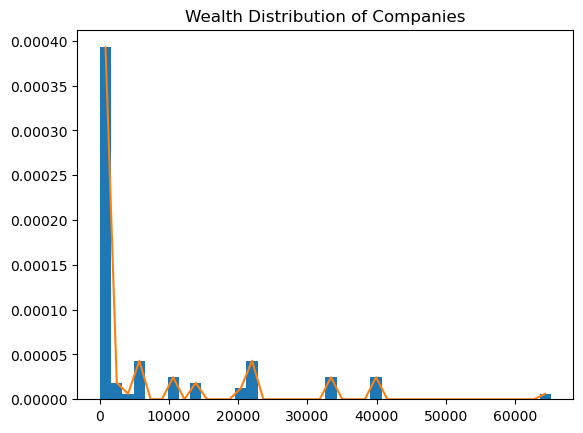

In [299]:
ValueDistribution = Modeldata.xs(sim_length-1, level="Step")["Value"]
bin_heights, bin_edges, _ = plt.hist(ValueDistribution,bins = 40, density = True, stacked = True)
bin_centres = bin_edges[:-1] + np.diff(bin_edges)/2
plt.plot(bin_centres,bin_heights)
plt.title('Wealth Distribution of Companies')